In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import os
import pickle
from tqdm import tqdm

class DatasetProcessor:
    ACC_RESOLUTION = 13
    ACC_RANGE = 16  # in g
    GYRO_RESOLUTION = 16
    GYRO_RANGE = 2000  # in degrees per second

    def get_file_name(self, path):
        """Get all .txt files from the dataset directory including subfolders"""
        allfiles = []
        allFolders = sorted(glob.glob(path + "*/"))
        print(f"Found folders: {allFolders}")

        for folder in allFolders:
            files_list = sorted(glob.glob(folder + "*.txt"))
            if len(files_list) == 0:
                print(f"No .txt files found in folder: {folder}")
            else:
                allfiles.append(files_list)

        if len(allfiles) == 0:
            raise ValueError("No valid dataset files found. Please check your dataset path.")

        dataset = np.hstack(allfiles)
        if len(dataset) == 0:
            raise ValueError("Dataset is empty after processing.")
        return dataset

    def __read_data(self, data_path):
        """Read data and convert to physical units"""
        data = pd.read_csv(data_path, header=None)
        data = data.iloc[:, :6]  # Select only the first 6 columns
        data.columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

        # Convert raw data to physical units
        data[['acc_x', 'acc_y', 'acc_z']] = data[['acc_x', 'acc_y', 'acc_z']].apply(
            lambda x: ((2 * self.ACC_RANGE) / (2 ** self.ACC_RESOLUTION)) * x)
        data[['gyro_x', 'gyro_y', 'gyro_z']] = data[['gyro_x', 'gyro_y', 'gyro_z']].apply(
            lambda x: ((2 * self.GYRO_RANGE) / (2 ** self.GYRO_RESOLUTION)) * x)

        # Add key features for fall detection
        # Acceleration magnitude
        data['acc_magnitude'] = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)

        # Gyroscope magnitude (angular velocity)
        data['gyro_magnitude'] = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)

        return data

    def __get_label(self, data_path):
        """Extract label from file name (D = normal activity, F = fall)"""
        label_char = os.path.basename(data_path)[0]
        if label_char == 'D':
            return int(0)  # Non-fall activity
        elif label_char == 'F':
            return int(1)  # Fall activity
        else:
            raise ValueError(f"Unknown label in file: {data_path}")

    def __add_label(self, data_path):
        """Read data and add label column"""
        dataset = self.__read_data(data_path)
        dataset['label'] = self.__get_label(data_path)
        return dataset.to_numpy()

    def datasets_to_nparray(self, datasets_address_array, outputsize=20000000, column_dimension=9):
        """Convert all datasets to a single numpy array"""
        # Initialize an array to store data and labels
        result = np.zeros((outputsize, column_dimension), 'float32')
        first_index = 0

        for address in tqdm(datasets_address_array, desc="Loading files"):
            feature = self.__add_label(address)
            if first_index + len(feature) > outputsize:
                print(f"Warning: Output array size ({outputsize}) is not enough, truncating data.")
                break
            result[first_index: (first_index + len(feature))] = feature
            first_index += len(feature)

        # Remove unused rows
        return result[0:first_index]

    def windowing3d(self, dataset, window_size=200, overlap=0.5):
        """
        Apply windowing to the dataset

        Args:
            dataset: Numpy array with shape (samples, features)
            window_size: Number of samples in each window
            overlap: Overlap ratio between windows

        Returns:
            X: Features with shape (windows, window_size, features)
            y: Labels with shape (windows,)
        """
        step = int(window_size * (1 - overlap))
        num_features = dataset.shape[1] - 1  # Excluding the label column

        # Calculate how many windows we'll have
        num_windows = (dataset.shape[0] - window_size) // step + 1

        # Prepare arrays for features and labels
        X = np.zeros((num_windows, window_size, num_features), dtype='float32')
        y = np.zeros(num_windows, dtype='int32')

        # Fill the arrays
        for i in tqdm(range(num_windows), desc="Creating windows"):
            start_idx = i * step
            end_idx = start_idx + window_size

            window_data = dataset[start_idx:end_idx, :-1]  # All columns except label
            X[i] = window_data

            # Use majority vote for the label of this window
            window_labels = dataset[start_idx:end_idx, -1]
            y[i] = np.round(np.mean(window_labels))

        return X, y

    def split_data(self, X, y, ratio=0.8):
        """Split data into training and testing sets"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=ratio, stratify=y, random_state=42
        )
        return X_train, y_train, X_test, y_test

    def normalizer(self, X_train, X_test):
        """Normalize data using StandardScaler"""
        # Get original shapes
        train_samples, train_timesteps, train_features = X_train.shape
        test_samples, test_timesteps, test_features = X_test.shape

        # Reshape to 2D for scaling
        X_train_reshaped = X_train.reshape(-1, train_features)
        X_test_reshaped = X_test.reshape(-1, test_features)

        # Fit scaler on training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_test_scaled = scaler.transform(X_test_reshaped)

        # Reshape back to 3D
        X_train = X_train_scaled.reshape(train_samples, train_timesteps, train_features)
        X_test = X_test_scaled.reshape(test_samples, test_timesteps, test_features)

        return X_train, X_test

    def generate_class_weight(self, y_train):
        """Generate class weights for imbalanced dataset"""
        unique_classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight="balanced",
                                            classes=unique_classes,
                                            y=y_train)
        class_weight_dict = dict(zip(unique_classes, class_weights))
        print(f"Class weights: {class_weight_dict}")
        return class_weight_dict

# Functions for saving and loading with pickle
def save_pickle(data, filename):
    """Save data to a pickle file"""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

def load_pickle(filename):
    """Load data from a pickle file"""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}")
    return data

In [ ]:
# Main processing script
if __name__ == "__main__":
    # Initialize the data processor
    data_processor = DatasetProcessor()

    # Path to your dataset
    dataset_path = '/content/drive/MyDrive/SisFall_dataset/'

    # Flag to control whether to process data or load from saved files
    save_data = True  # Set to False if you want to load from saved files

    if save_data:
        print('Step 1: Getting file paths...')
        dataset_files = data_processor.get_file_name(dataset_path)
        print(f"Found {len(dataset_files)} files")

        print("Step 2: Converting dataset files to NumPy array with labels...")
        dataset = data_processor.datasets_to_nparray(dataset_files)
        print(f"Dataset shape after conversion: {dataset.shape}")

        print("Step 3: Applying windowing...")
        X, y = data_processor.windowing3d(dataset, window_size=200, overlap=0.5)
        print(f"Feature shape: {X.shape}, Label shape: {y.shape}")

        print("Step 4: Splitting data into train and test sets...")
        X_train, y_train, X_test, y_test = data_processor.split_data(X, y, ratio=0.8)
        print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

        print("Step 5: Normalizing the dataset...")
        X_train, X_test = data_processor.normalizer(X_train, X_test)
        print("Normalization completed.")

        # Save the processed data
        print("Step 6: Saving processed data...")
        save_pickle(X_train, '/content/drive/MyDrive/SisFall_features_final/X_train.pkl')
        save_pickle(y_train, '/content/drive/MyDrive/SisFall_features_final/y_train.pkl')
        save_pickle(X_test, '/content/drive/MyDrive/SisFall_features_final/X_test.pkl')
        save_pickle(y_test, '/content/drive/MyDrive/SisFall_features_final/y_test.pkl')

        # Generate class weights
        class_weight = data_processor.generate_class_weight(y_train)
        save_pickle(class_weight, '/content/drive/MyDrive/SisFall_features_final/class_weight.pkl')
    else:
        # Load the preprocessed data
        print("Loading preprocessed data from files...")
        X_train = load_pickle('/content/drive/MyDrive/SisFall_features_final/X_train.pkl')
        y_train = load_pickle('/content/drive/MyDrive/SisFall_features_final/y_train.pkl')
        X_test = load_pickle('/content/drive/MyDrive/SisFall_features_final/X_test.pkl')
        y_test = load_pickle('/content/drive/MyDrive/SisFall_features_final/y_test.pkl')

        # Load or generate class weights
        try:
            class_weight = load_pickle('/content/drive/MyDrive/SisFall_features_final/class_weight.pkl')
        except:
            print("Generating class weights...")
            class_weight = data_processor.generate_class_weight(y_train)

    print("Data preprocessing completed successfully!")
    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Step 1: Getting file paths...
Found folders: ['/content/drive/MyDrive/SisFall_dataset/SA01/', '/content/drive/MyDrive/SisFall_dataset/SA02/', '/content/drive/MyDrive/SisFall_dataset/SA03/', '/content/drive/MyDrive/SisFall_dataset/SA04/', '/content/drive/MyDrive/SisFall_dataset/SA05/', '/content/drive/MyDrive/SisFall_dataset/SA06/', '/content/drive/MyDrive/SisFall_dataset/SA07/', '/content/drive/MyDrive/SisFall_dataset/SA08/', '/content/drive/MyDrive/SisFall_dataset/SA09/', '/content/drive/MyDrive/SisFall_dataset/SA10/', '/content/drive/MyDrive/SisFall_dataset/SA11/', '/content/drive/MyDrive/SisFall_dataset/SA12/', '/content/drive/MyDrive/SisFall_dataset/SA13/', '/content/drive/MyDrive/SisFall_dataset/SA14/', '/content/drive/MyDrive/SisFall_dataset/SA15/', '/content/drive/MyDrive/SisFall_dataset/SA16/', '/content/drive/MyDrive/SisFall_dataset/SA17/', '/content/drive/MyDrive/SisFall_dataset/SA18/', '/content/drive/MyDrive/SisFall_dataset/SA19/', '/content/drive/MyDrive/SisFall_dataset/SA

Loading files: 100%|██████████| 4505/4505 [32:51<00:00,  2.28it/s]


Dataset shape after conversion: (15858929, 9)
Step 3: Applying windowing...


Creating windows: 100%|██████████| 158588/158588 [00:04<00:00, 31941.45it/s]


Feature shape: (158588, 200, 8), Label shape: (158588,)
Step 4: Splitting data into train and test sets...
Train set shape: (126870, 200, 8), Test set shape: (31718, 200, 8)
Step 5: Normalizing the dataset...
Normalization completed.
Step 6: Saving processed data...
Data saved to /content/drive/MyDrive/SisFall_features_final/X_train.pkl
Data saved to /content/drive/MyDrive/SisFall_features_final/y_train.pkl
Data saved to /content/drive/MyDrive/SisFall_features_final/X_test.pkl
Data saved to /content/drive/MyDrive/SisFall_features_final/y_test.pkl
Class weights: {0: 0.7576952019206651, 1: 1.4701383577834943}
Data saved to /content/drive/MyDrive/SisFall_features_final/class_weight.pkl
Data preprocessing completed successfully!
Training data shape: (126870, 200, 8), (126870,)
Testing data shape: (31718, 200, 8), (31718,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

def build_cnn_lstm_model(input_shape):
    """
    Create a CNN+LSTM model for fall detection

    Args:
        input_shape: Shape of input data (window_size, features)

    Returns:
        Compiled Keras model
    """
    model = Sequential()

    # CNN layers for feature extraction
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM layers for temporal dependencies
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

def train_model(model, X_train, y_train, X_val, y_val, class_weights=None,
                batch_size=32, epochs=50, model_path='best_model.h5'):
    """
    Train the model with callbacks for early stopping and checkpointing

    Args:
        model: Compiled Keras model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        class_weights: Class weights for imbalanced data
        batch_size: Batch size
        epochs: Maximum number of epochs
        model_path: Path to save best model

    Returns:
        Training history
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )

    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data

    Args:
        model: Trained Keras model
        X_test, y_test: Test data

    Returns:
        Dictionary with evaluation metrics
    """
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")

    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate other metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    evaluation = {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc': {
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        }
    }

    return evaluation

def visualize_results(history, evaluation):
    """
    Visualize training history and evaluation results

    Args:
        history: Training history from model.fit
        evaluation: Evaluation results from evaluate_model
    """
    # Create a 2x2 grid of plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot training & validation accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Validation'], loc='upper right')

    # Plot confusion matrix
    cm = evaluation['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')
    axs[1, 0].set_ylabel('True label')
    axs[1, 0].set_xlabel('Predicted label')

    # Plot ROC curve
    axs[1, 1].plot(evaluation['roc']['fpr'], evaluation['roc']['tpr'],
                   label=f'ROC curve (area = {evaluation["roc"]["auc"]:.3f})')
    axs[1, 1].plot([0, 1], [0, 1], 'k--')
    axs[1, 1].set_xlim([0.0, 1.0])
    axs[1, 1].set_ylim([0.0, 1.05])
    axs[1, 1].set_xlabel('False Positive Rate')
    axs[1, 1].set_ylabel('True Positive Rate')
    axs[1, 1].set_title('Receiver Operating Characteristic')
    axs[1, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('fall_detection_results.png')
    plt.show()

    # Print classification report
    report = evaluation['classification_report']
    print("\nClassification Report:")
    print(f"Precision (Fall): {report['1']['precision']:.4f}")
    print(f"Recall (Fall): {report['1']['recall']:.4f}")
    print(f"F1-Score (Fall): {report['1']['f1-score']:.4f}")
    print(f"Precision (No Fall): {report['0']['precision']:.4f}")
    print(f"Recall (No Fall): {report['0']['recall']:.4f}")
    print(f"F1-Score (No Fall): {report['0']['f1-score']:.4f}")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")

Loading preprocessed data...
Data loaded from /content/drive/MyDrive/SisFall_features_final/X_train.pkl
Data loaded from /content/drive/MyDrive/SisFall_features_final/y_train.pkl
Data loaded from /content/drive/MyDrive/SisFall_features_final/X_test.pkl
Data loaded from /content/drive/MyDrive/SisFall_features_final/y_test.pkl
Data loaded from /content/drive/MyDrive/SisFall_features_final/class_weight.pkl
Training set: (101496, 200, 8), (101496,)
Validation set: (25374, 200, 8), (25374,)
Test set: (31718, 200, 8), (31718,)
Loading existing model from /content/drive/MyDrive/SisFall_models/cnn_lstm_model.h5


Evaluating model on test data...
992/992 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9178 - loss: 0.2146
Test accuracy: 0.9181
992/992 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step


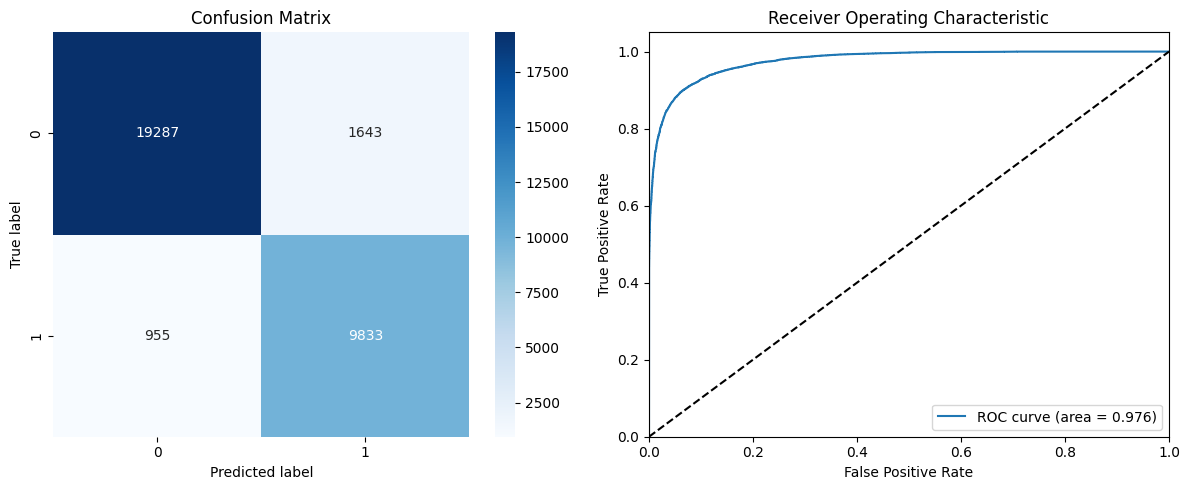


Classification Report:
Precision (Fall): 0.8568
Recall (Fall): 0.9115
F1-Score (Fall): 0.8833
Precision (No Fall): 0.9528
Recall (No Fall): 0.9215
F1-Score (No Fall): 0.9369
Overall Accuracy: 0.9181


In [ ]:
# Main script for model training and evaluation
if __name__ == "__main__":
    import os
    import pickle
    import numpy as np
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import load_model

    # Functions for saving and loading with pickle
    def load_pickle(filename):
        """Load data from a pickle file"""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Data loaded from {filename}")
        return data

    # Set paths
    data_path = '/content/drive/MyDrive/SisFall_features_final/'
    model_path = '/content/drive/MyDrive/SisFall_models/cnn_lstm_model.h5'

    # Create model directory if it doesn't exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    # Load preprocessed data
    print("Loading preprocessed data...")
    X_train = load_pickle(os.path.join(data_path, 'X_train.pkl'))
    y_train = load_pickle(os.path.join(data_path, 'y_train.pkl'))
    X_test = load_pickle(os.path.join(data_path, 'X_test.pkl'))
    y_test = load_pickle(os.path.join(data_path, 'y_test.pkl'))

    # Try to load class weights if they exist
    try:
        class_weights = load_pickle(os.path.join(data_path, 'class_weight.pkl'))
    except:
        # If no class weights file, calculate them
        from sklearn.utils import compute_class_weight
        unique_classes = np.unique(y_train)
        class_weights_arr = compute_class_weight(class_weight="balanced",
                                             classes=unique_classes,
                                             y=y_train)
        class_weights = dict(zip(unique_classes, class_weights_arr))
        print(f"Calculated class weights: {class_weights}")

    # Split training data to create a validation set
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    print(f"Training set: {X_train_split.shape}, {y_train_split.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")

    # Check if model already exists
    train_new_model = False  # Set to False if you want to load a saved model

    if train_new_model or not os.path.exists(model_path):
        # Build the model
        print("Building and training a new model...")
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_cnn_lstm_model(input_shape)
        model.summary()

        # Train the model
        history = train_model(
            model, X_train_split, y_train_split, X_val, y_val,
            class_weights=class_weights,
            batch_size=32,
            epochs=50,
            model_path=model_path
        )
    else:
        # Load existing model
        print(f"Loading existing model from {model_path}")
        model = load_model(model_path)
        history = None  # No history available for pre-trained model

    # Evaluate the model
    print("Evaluating model on test data...")
    evaluation = evaluate_model(model, X_test, y_test)

    # Visualize results if we have training history
    if history:
        visualize_results(history, evaluation)
    else:
        # Just create visualization for evaluation metrics without training history
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot confusion matrix
        cm = evaluation['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0])
        axs[0].set_title('Confusion Matrix')
        axs[0].set_ylabel('True label')
        axs[0].set_xlabel('Predicted label')

        # Plot ROC curve
        axs[1].plot(evaluation['roc']['fpr'], evaluation['roc']['tpr'],
                   label=f'ROC curve (area = {evaluation["roc"]["auc"]:.3f})')
        axs[1].plot([0, 1], [0, 1], 'k--')
        axs[1].set_xlim([0.0, 1.0])
        axs[1].set_ylim([0.0, 1.05])
        axs[1].set_xlabel('False Positive Rate')
        axs[1].set_ylabel('True Positive Rate')
        axs[1].set_title('Receiver Operating Characteristic')
        axs[1].legend(loc="lower right")

        plt.tight_layout()
        plt.savefig('fall_detection_evaluation.png')
        plt.show()

        # Print classification report
        report = evaluation['classification_report']
        print("\nClassification Report:")
        print(f"Precision (Fall): {report['1']['precision']:.4f}")
        print(f"Recall (Fall): {report['1']['recall']:.4f}")
        print(f"F1-Score (Fall): {report['1']['f1-score']:.4f}")
        print(f"Precision (No Fall): {report['0']['precision']:.4f}")
        print(f"Recall (No Fall): {report['0']['recall']:.4f}")
        print(f"F1-Score (No Fall): {report['0']['f1-score']:.4f}")
        print(f"Overall Accuracy: {report['accuracy']:.4f}")

In [ ]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

# Path to your data directory
data_path = '/content/drive/MyDrive/SisFall_features_final/'  # Adjust to your path

# Load your training data
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}")
    return data

X_train = load_pickle(os.path.join(data_path, 'X_train.pkl'))

# Get original shape
train_samples, train_timesteps, train_features = X_train.shape

# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, train_features)

# Fit scaler
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# Save scaler
scaler_path = os.path.join(data_path, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

Data loaded from /content/drive/MyDrive/SisFall_features_final/X_train.pkl
Scaler saved to /content/drive/MyDrive/SisFall_features_final/scaler.pkl


Loading model from /content/drive/MyDrive/SisFall_models/cnn_lstm_model.h5...


Loading data from /content/drive/MyDrive/mpucsv/mpu6050_data_20250307_202643.csv...
Timestamp column found. Removing it from processing data.
Creating 77 windows...
Loaded scaler from /content/drive/MyDrive/SisFall_features_final/scaler.pkl
Making predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
No falls detected.
No falls detected.

Average fall probability: 0.0037


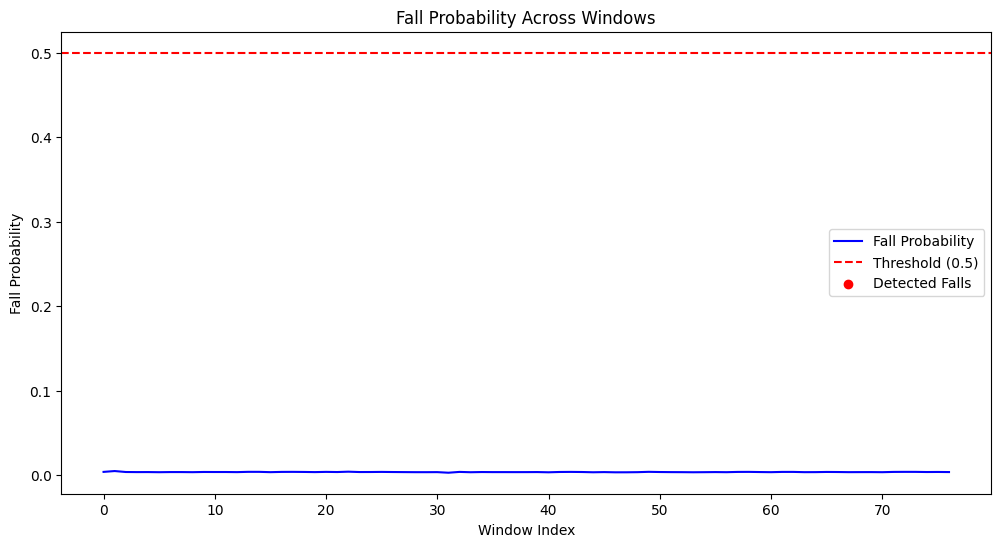

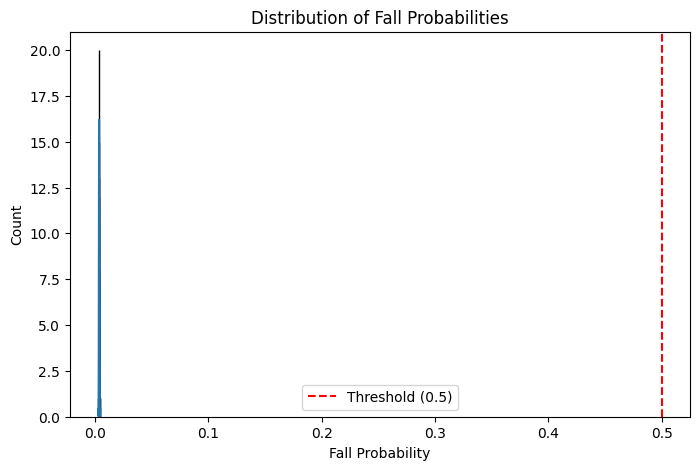

Results saved to fall_detection_results.pkl


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
def load_pickle(filename):
    """Load data from a pickle file"""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}")
    return data

def preprocess_mpu6050_data(csv_file, window_size=200, overlap=0.5):
    """
    Preprocess MPU6050 data for fall detection model

    Args:
        csv_file: Path to CSV file with MPU6050 data
        window_size: Size of window for segmentation
        overlap: Overlap between windows

    Returns:
        Preprocessed windows ready for model input
    """
    # 1. Load the data
    print(f"Loading data from {csv_file}...")
    data = pd.read_csv(csv_file)

    # 2. Handle timestamp column if present
    if 'timestamp' in data.columns:
        print("Timestamp column found. Removing it from processing data.")
        data = data.drop('timestamp', axis=1)

    # 3. Ensure column names match expected format
    expected_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
    if not all(col in data.columns for col in expected_columns):
        print("Column names don't match expected format. Renaming columns...")
        # Check if we have enough columns
        if len(data.columns) >= 6:
            # Take the first 6 columns and rename them
            column_mapping = {
                data.columns[0]: 'acc_x',
                data.columns[1]: 'acc_y',
                data.columns[2]: 'acc_z',
                data.columns[3]: 'gyro_x',
                data.columns[4]: 'gyro_y',
                data.columns[5]: 'gyro_z'
            }
            data = data.rename(columns=column_mapping)
            # Keep only the relevant columns
            data = data[expected_columns]
        else:
            raise ValueError(f"CSV file must have at least 6 columns for accelerometer and gyroscope data. Found: {len(data.columns)}")

    # 4. Add derived features (same as in training)
    # Acceleration magnitude
    data['acc_magnitude'] = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)

    # Gyroscope magnitude
    data['gyro_magnitude'] = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)

    # 5. Apply windowing
    step = int(window_size * (1 - overlap))
    num_features = len(data.columns)

    # Calculate how many windows we'll have
    num_windows = (len(data) - window_size) // step + 1
    if num_windows <= 0:
        raise ValueError(f"Data too short ({len(data)} samples) for window size {window_size}")

    print(f"Creating {num_windows} windows...")
    # Create windows
    X = np.zeros((num_windows, window_size, num_features), dtype='float32')

    for i in range(num_windows):
        start_idx = i * step
        end_idx = start_idx + window_size

        window_data = data.iloc[start_idx:end_idx].values
        X[i] = window_data

    return X
def load_scaler(data_path):
    """
    Load or recreate scaler from saved training data

    Returns:
        Fitted StandardScaler
    """
    # Try to load scaler if saved
    scaler_path = os.path.join(data_path, 'scaler.pkl')
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print(f"Loaded scaler from {scaler_path}")
        return scaler

    # If no saved scaler, fit a new one on training data
    print("No saved scaler found. Creating new scaler from X_train...")
    X_train = load_pickle(os.path.join(data_path, 'X_train.pkl'))

    # Get original shape
    train_samples, train_timesteps, train_features = X_train.shape

    # Reshape to 2D for scaling
    X_train_reshaped = X_train.reshape(-1, train_features)

    # Fit scaler
    scaler = StandardScaler()
    scaler.fit(X_train_reshaped)

    return scaler

def normalize_windows(X, scaler):
    """
    Normalize windows using the provided scaler

    Args:
        X: Windows of shape (num_windows, window_size, features)
        scaler: Fitted StandardScaler

    Returns:
        Normalized windows
    """
    # Get original shape
    samples, timesteps, features = X.shape

    # Reshape to 2D for scaling
    X_reshaped = X.reshape(-1, features)

    # Apply scaling
    X_scaled = scaler.transform(X_reshaped)

    # Reshape back to 3D
    X_normalized = X_scaled.reshape(samples, timesteps, features)

    return X_normalized

def test_fall_detection(model_path, data_path, csv_file, window_size=200, overlap=0.5, threshold=0.5):
    """
    Test fall detection model on new MPU6050 data

    Args:
        model_path: Path to saved model
        data_path: Path to directory with training data and scaler
        csv_file: Path to CSV file with new MPU6050 data
        window_size: Size of window for segmentation
        overlap: Overlap between windows
        threshold: Threshold for fall detection

    Returns:
        Predictions for each window
    """
    # 1. Load model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)

    # 2. Preprocess data
    X = preprocess_mpu6050_data(csv_file, window_size, overlap)

    # 3. Load or create scaler
    scaler = load_scaler(data_path)

    # 4. Normalize data
    X_normalized = normalize_windows(X, scaler)

    # 5. Make predictions
    print("Making predictions...")
    predictions_prob = model.predict(X_normalized)
    predictions = (predictions_prob > threshold).astype(int)

    return predictions_prob, predictions, X


def visualize_results(predictions_prob, predictions, windows):
    """
    Visualize the fall detection results.

    Args:
        predictions_prob: Probability predictions for each window.
        predictions: Binary classification results.
        windows: Raw segmented data used for classification.
    """
    num_windows = len(predictions_prob)

    # Plot fall probabilities
    plt.figure(figsize=(12, 6))
    plt.plot(range(num_windows), predictions_prob, label='Fall Probability', color='b')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
    plt.scatter(np.where(predictions == 1)[0], predictions_prob[predictions == 1],
            color='red', marker='o', label='Detected Falls')

    plt.xlabel('Window Index')
    plt.ylabel('Fall Probability')
    plt.title('Fall Probability Across Windows')
    plt.legend()
    plt.show()

    # Histogram of fall probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(predictions_prob, bins=20, kde=True, color='blue')
    plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
    plt.xlabel('Fall Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Fall Probabilities')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set paths
    model_path = '/content/drive/MyDrive/SisFall_models/cnn_lstm_model.h5'
    data_path = '/content/drive/MyDrive/SisFall_features_final/'
    csv_file = '/content/drive/MyDrive/mpucsv/mpu6050_data_20250307_202643.csv'  # Replace with your file path

    # Test the model
    predictions_prob, predictions, windows = test_fall_detection(
        model_path=model_path,
        data_path=data_path,
        csv_file=csv_file,
        window_size=200,  # Should match your training window size
        overlap=0.5,      # Should match your training overlap
        threshold=0.5     # Adjust as needed
    )

    # Print results
    fall_windows = np.where(predictions == 1)[0]
    if len(fall_windows) > 0:
        print(f"Falls detected in {len(fall_windows)} windows!")
        for window in fall_windows:
            prob = predictions_prob[window][0]
            print(f"  Window {window}: Fall probability {prob:.4f}")
    else:
        print("No falls detected.")

    fall_windows = np.where(predictions == 1)[0]

    if len(fall_windows) > 0:
        consecutive_falls = []
        print(f"Falls detected in {len(fall_windows)} windows!")

        for i in range(len(fall_windows)):
            window = fall_windows[i]
            prob = predictions_prob[window][0]

            # Check for consecutive falls
            if i > 0 and fall_windows[i] == fall_windows[i - 1] + 1:
                consecutive_falls.append((window, prob))
            else:
                # If the sequence breaks, check if previous sequence had more than 3
                if len(consecutive_falls) >= 3:
                    print("\n🚨 Fall Detected! 🚨")
                    for w, p in consecutive_falls:
                        print(f"  Window {w}: Fall probability {p:.4f}")
                consecutive_falls = [(window, prob)]  # Start a new sequence

        # Check the last sequence
        if len(consecutive_falls) >= 3:
            print("\n🚨 Fall Detected! 🚨")
            for w, p in consecutive_falls:
                print(f"  Window {w}: Fall probability {p:.4f}")

    else:
        print("No falls detected.")

    # Additional analysis (optional)
    print(f"\nAverage fall probability: {predictions_prob.mean():.4f}")

    # You can save the results
    results = {
        'windows': len(predictions),
        'predictions': predictions,
        'probabilities': predictions_prob,
        'fall_windows': fall_windows
    }
    # Call the function after making predictions
    visualize_results(predictions_prob, predictions, windows)
    # Save results to pickle file
    with open('fall_detection_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("Results saved to fall_detection_results.pkl")